# **Project: Depth Estimation**

# **Introduction**

Monocular cameras struggle with depth ambiguity, as they cannot determine how far objects are in a scene. While two-view reconstruction can estimate 3D points using triangulation, the result lacks a metric scale (Project 3). This is where a **stereo camera** comes in—a system with two cameras placed side by side, separated by a known baseline (distance between cameras).

A stereo camera solves the depth problem by analyzing the disparity between corresponding points in the two images. Using the baseline and disparity, we can calculate the depth of objects in the scene. This technique provides accurate metric depth information, critical for applications like robotics, 3D reconstruction, and autonomous systems.





In [1]:
!pip install matplotlib
!pip install transforms3d
!pip install pyrender
!pip install opencv-python
!pip install open3d

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2

EPS = 1e-8


In [3]:
#remove if there is any exisiting folder
!rm -rf *

'rm' is not recognized as an internal or external command,
operable program or batch file.


# **Step 1: Load Data**

In [ ]:
!gdown "https://drive.google.com/uc?id=126-_jJtQowBRTpsNieMDTPgjDW4VYaHa"

# Unzip the downloaded file
!unzip -q two_view_stereo.zip
# Ensure all files are editable
!chmod -R u+w two_view_stereo

Downloading...
From: https://drive.google.com/uc?id=126-_jJtQowBRTpsNieMDTPgjDW4VYaHa
To: /content/two_view_stereo.zip
100% 11.7M/11.7M [00:00<00:00, 57.1MB/s]


Loading two_view_stereo/data/templeRing


47it [00:00, 73.74it/s]


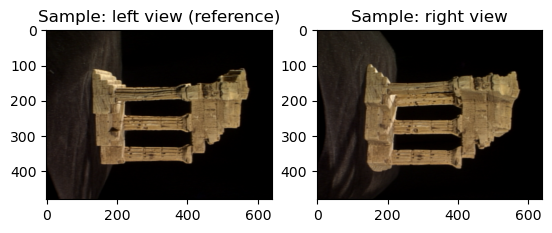

In [4]:
# Load data
from two_view_stereo.dataloader import load_middlebury_data
DATA = load_middlebury_data("two_view_stereo/data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]


plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()


# **Step 2 : Rectify two views**

## **(2a) Understanding Camera Configuration**

### 1. World to Camera Transformation

- A 3D point $ P_w $ in the world coordinate system is transformed to the camera's coordinate system:
  $$
  P_i = R_{iw} \cdot P_w + T_{wi}
  $$
  - $ R_{iw} $: Rotation matrix from the world to the camera's coordinate system.
  -$ T_{wi} $: Translation vector representing the camera's position in the world.


You will need to compute the right-to-left transformation:

$$
P_i = R_{ij} \cdot P_j + T_{ij}
$$

and the baseline \( B \).

where  B : Baseline is the distance between the two camera centers:
  $$
  B = \|T_{ij}\|
  $$
  
  Complete the function `compute_right2left_transformation` in `two_view_stereo.py`


In [5]:
from two_view_stereo.two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

# Load rotation (R) and translation (T) matrices for the left (view_i) and right (view_j) cameras
# These describe how each camera is positioned relative to the world.
R_wi, T_wi = view_i["R"], view_i["T"][:, None]  # Left camera: p_i = R_wi @ p_w + T_wi
R_wj, T_wj = view_j["R"], view_j["T"][:, None]  # Right camera: p_j = R_wj @ p_w + T_wj

# Step 1: Compute the transformation to convert coordinates from the right view to the left view
# R_ji: Rotation matrix from the right camera's coordinate system to the left's
# T_ji: Translation vector from the right camera to the left camera
# B: Baseline (distance between the two cameras)
R_ji, T_ji, B = compute_right2left_transformation(R_wi, T_wi, R_wj, T_wj)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Compute $ R_{\text{rect}} $ to align the epipole $ e_i $ with the y-axis $[0, 1, 0]^T$, ensuring it points to y-infinity (accounting for clockwise image rotation). Use cross-products to calculate the new axes.


In [6]:
# This checks that the left camera is to the left of the right camera.
assert T_ji[1, 0] > 0, "here we assume view i should be on the left, not on the right"

# Step 2: Compute the rectification rotation matrix for the left view
# This matrix aligns the left camera's view to a "rectified" coordinate system.
R_irect = compute_rectification_R(T_ji)

We implemented half of the two-view calibration for you after getting Rrect
i . Complete
the function `rectify_2view` by first computing the homography and then using cv2.warpPerspective
to warp the image. When warping the image, use the target shape we computed for you as
dsize=(w max, h max). We are using the Kcorr (already computed for you) here to enlarge the pictures and eliminate
black areas after warping.


Compute homography for both left and right images$$
H_i = K_{i_{\text{corr}}} \cdot \left( R_{\text{irect}} \cdot K_i^{-1} \right)
$$


In [7]:
# Step 3: Rectify both images
# This step adjusts both camera views so that corresponding points in the two images are aligned.
rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,                # Rectification rotation matrix for the left camera
    R_irect @ R_ji,         # Rectification rotation matrix for the right camera
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)

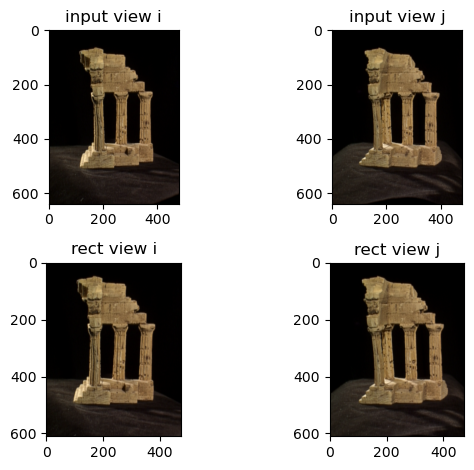

In [8]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()

# **Step 3: Compute the Disparity**

In [9]:
# Import necessary functions
from two_view_stereo.two_view_stereo import image2patch, ssd_kernel

# Ensure intrinsic parameters are consistent between the two rectified images
# These checks make sure the camera's intrinsic properties (like focal length) match as expected.
assert K_i_corr[1, 1] == K_j_corr[1, 1], "The focal lengths in the Y direction must be the same."
assert (K_i_corr[0] == K_j_corr[0]).all(), "The intrinsic matrices must match along the X dimension."
assert (
    rgb_i_rect.shape == rgb_j_rect.shape
), "The rectified images must have the same shape (height and width)."

# Get the dimensions of the rectified images (height and width)
h, w = rgb_i_rect.shape[:2]

# Compute the disparity offset `d0`:
# This accounts for the difference in principal points (the centers of the images) between the two cameras.
d0 = K_j_corr[1, 2] - K_i_corr[1, 2]


### (a) **Extract Patches from the Image**
We are going to compare the patch and complete the function `image2patch` using **zero padding** on the border.  
- **Note:** Ensure the function works when \( k\_size = 1 \).

In [10]:
# Convert the images to patches for comparison
# Divide pixel values by 255.0 to normalize them to the range [0, 1].
# `image2patch` extracts small overlapping patches of size 3x3 around each pixel.
patches_i = image2patch(rgb_i_rect.astype(float) / 255.0, 3)  # Patches from the left image
patches_j = image2patch(rgb_j_rect.astype(float) / 255.0, 3)  # Patches from the right image


#### **SSD (Sum of Squared Differences):**
Complete `ssd_kernel` function. The metrics treat each RGB value as one grayscale channel and finally you should sum the three (R, G, B) channels (sum across the channels at each pixel, i.e., [H, W, 3] would go to [H, W]).  
The input of each kernel function is a `src` [M, K \times K, 3] that contains  M  left patches and a `dst` [N, K \times K, 3] that contains  N right patches.  
You should output the metric with shape [M, N]. Each left patch should compare with each right patch.  
Try to use vectorized NumPy operations in the kernel functions.  
You are going to get an example plot for pixel (400, 200) of the left view and its matching score on the right view.


In [11]:
# Generate indices for the rows (v-coordinates) of the images
vi_idx, vj_idx = np.arange(h), np.arange(h)

# Compute disparity candidates:
# For each row in the left image (vi_idx), calculate potential disparity values (differences in row indices).
# Add the disparity offset `d0` to adjust for the camera's principal point difference.
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0

# Create a mask to filter out invalid disparity values
# Disparity values should always be positive.
valid_disp_mask = disp_candidates > 0.0

# Example: Compute similarity scores for a specific column `u` (e.g., column 400)
u = 400  # You can change this to analyze a different column

# Extract patches for the selected column `u` from both images
buf_i, buf_j = patches_i[:, u], patches_j[:, u]

# Compute the Sum of Squared Differences (SSD) similarity kernel:
# - The smaller the SSD value, the better the match.
value = ssd_kernel(buf_i, buf_j)

# Students: Why do we compute `_upper`?
# `_upper` is a placeholder for invalid matches. We set invalid values (not allowed by `valid_disp_mask`)
# to a very large number, ensuring they are not chosen as matches during disparity calculations.
_upper = value.max() + 1.0
value[~valid_disp_mask] = _upper


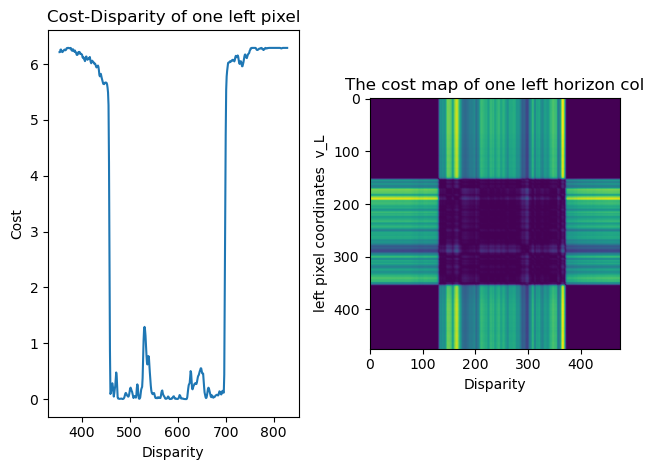

In [12]:
plt.subplot(1,2,1)
# Viz the  disparity-cost of u=500, v=200 on left view
v = 200
plt.title("Cost-Disparity of one left pixel")
plt.xlabel("Disparity")
plt.ylabel("Cost")
plt.plot(disp_candidates[v], value[v])
plt.subplot(1,2,2)
plt.title("The cost map of one left horizon col")
plt.xlabel("Disparity")
plt.ylabel("left pixel coordinates  v_L")
plt.imshow(value)
plt.tight_layout()
plt.show()

Now let's do the Left-Right consistency: in above right figure, the vertical axis is the left pixel coordinates and the horizontal axis is the right pixel (disparity).

When we find the minimal cost right view pixel for our reference pixel (e.g. find the minimum of the left figure), we only check the best matched right pixel patch, which corresponds to finding the minimum along the horizontal axis of the right cost map.

However, the matching from the left to the right and from the right to the left should be consistent. So we should also check the minimum of the vertical axis and see whether this two minimum agree with each other, below is an example


In [13]:
# example for the pixel (u=400,v=300) from the left view
v = 300
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)
#print(disp_candidates[v][best_matched_right_pixel] )

# example for the pixel (u=400,v=380) from the left view
v = 380
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)

300 300
True
380 113
False


#### **Compute Disparity :** Iterate over all u, complete the function `compute_disparity_map`

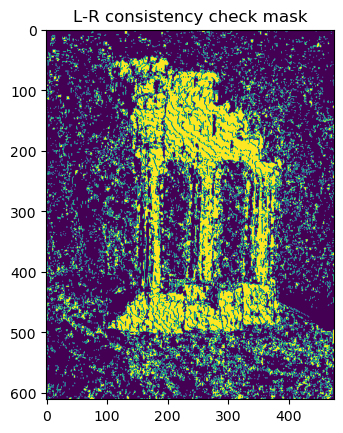

In [14]:
from two_view_stereo.two_view_stereo import compute_disparity_map

disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect, rgb_j_rect, d0=K_j_corr[1, 2] - K_i_corr[1, 2], k_size=5
)

plt.imshow(cv2.rotate(consistency_mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title("L-R consistency check mask")
plt.show()

# **Step 3: Compute Depth Map**

Given the disparity map computed above, complete
the function `compute_dep_and_pcl` that returns a depth map with shape [H,W] and also the back-
projected point cloud in camera frame with shape [H,W,3] where each pixel store the xyz coordinates
of the point cloud.

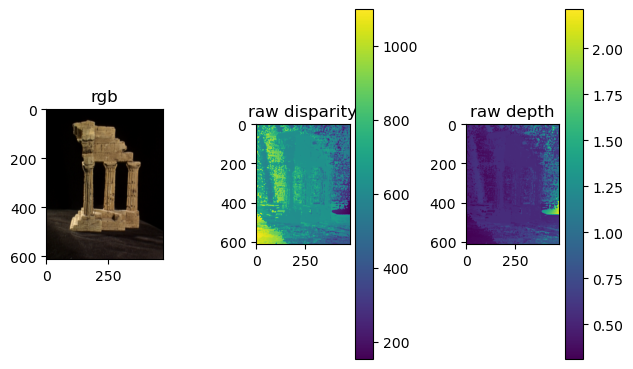

In [17]:
from two_view_stereo.two_view_stereo import compute_dep_and_pcl


# * 3. compute depth map and filter them
dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("raw disparity")
plt.imshow(cv2.rotate(disp_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("raw depth")
plt.imshow(cv2.rotate(dep_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.tight_layout()
plt.show()


Project Inspiration Credit to CIS580 Machine Perception
